In [12]:
%load_ext autoreload
%autoreload 1
import sys
import os
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).resolve().parent))

import pandas as pd 
pd.set_option('display.max_columns', 150)

from project.utils.data import *
%aimport project.utils.data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

from sktime.forecasting.all import temporal_train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = project.utils.data.load_extended_data()

# AutoR balance

План анализа для построения авторегрессионной модели:

- МПВ анализ
- Стационарность
- Автокорреляции
- Динамика дисперсии

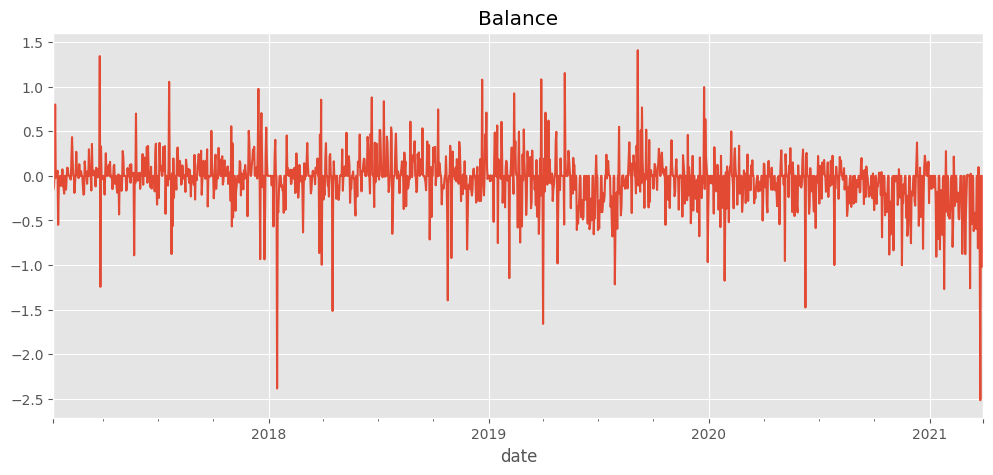

In [3]:
df.balance.plot();
plt.title('Balance');

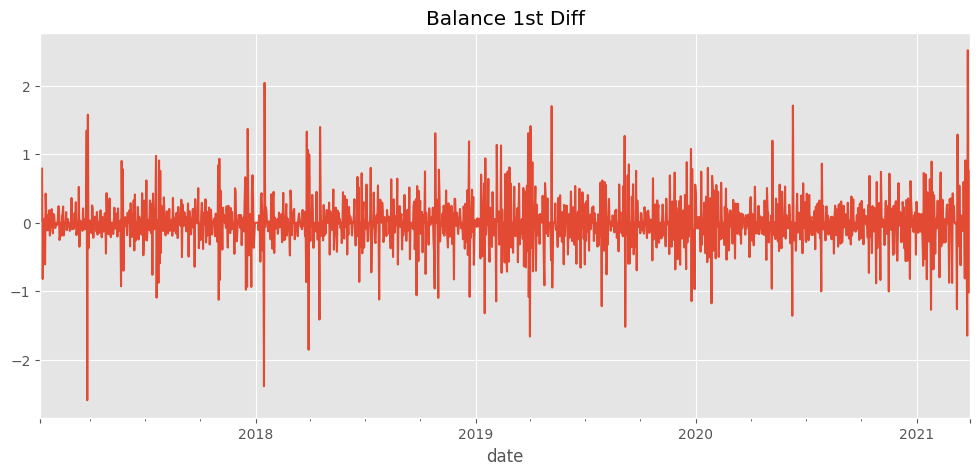

In [4]:
df.balance.diff().plot();
plt.title('Balance 1st Diff');

In [5]:
print('Balance: adf test p-value:', 
      round(
          adfuller(
              df.balance, maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
          )[1],3
      )
     )

Balance: adf test p-value: 0.024


In [7]:
# print('Balance adf test for 1st difference p-value:', 
#       round(
#           adfuller(
#               df.balance.diff().dropna(), maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
#           )[1],3
#       )
#      )

In [8]:
# print('Balance adf test for 2nd difference p-value:', 
#       round(
#           adfuller(
#               df.balance.diff(2).dropna(), maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
#           )[1],3
#       )
#      )

Во-первых, здесь и визуальный анализ (он же Метод Пристального Взгляда) говорит нам, что ряд **выглядит довольно стационарным**, по крайней мере в широком смысле

Да еще и тест Дики-Фуллера придает нам уверенности, тк отвергаем нулевую гипотезу на большинстве разумных уровнях значимости (alpha >= 0.05)

**справка**: нулевая гипотеза теста Дики-Фуллера предполагает наличие  единичного корня, т. е. нестационарность ряда. 

А раз считаем, что ряд слабо стационарный тооо, по [теореме Вольда](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%92%D0%BE%D0%BB%D0%B4%D0%B0) 
наш ряд должен быть представим виде $MA(\inf)$ (бесконечного скользящего среднего), который, в свою очередь, если мне не изменяет память, может быть представим в виде $ARMA(p, q)$ с конечными $p$ и $q$

А тогда, мы в общем-то имеем полное право примерить на ряд модель из класса SARIMA 

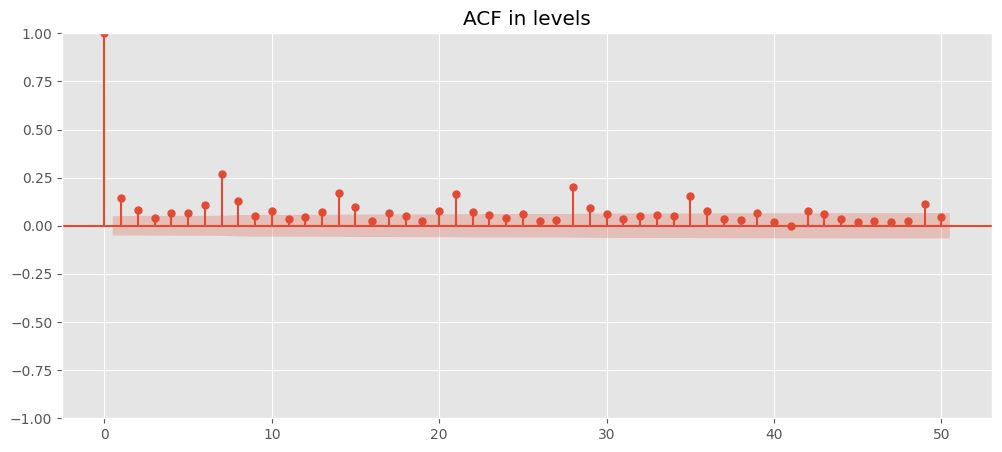

In [6]:
plot_acf(df.balance, title='ACF in levels', lags=50);

In [7]:
acf_res = acf(df.balance, nlags=50)

tr = 0.14
for index, lag in enumerate(acf_res):
    if lag > tr:
        print(index,end=' ')

0 1 7 14 21 28 35 

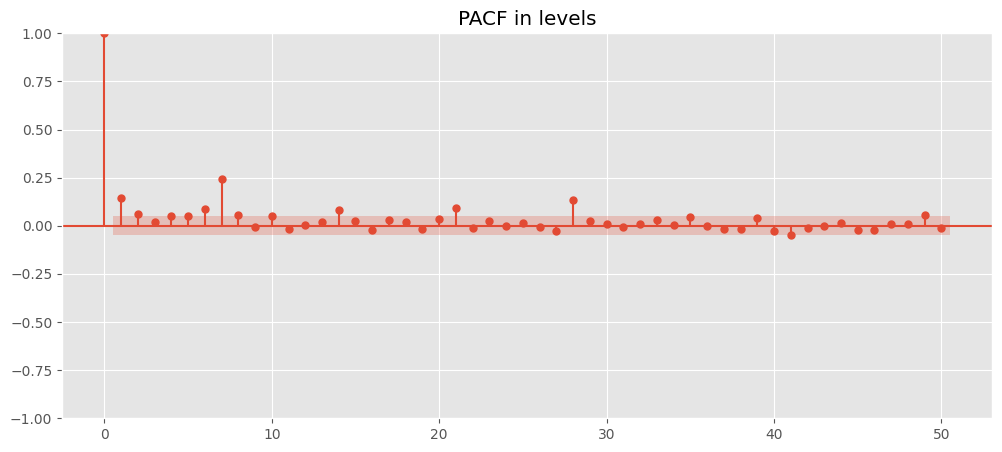

In [8]:
plot_pacf(df.balance, title='PACF in levels', lags=50);

In [9]:
pacf_res = pacf(df.balance, nlags=50)

tr = 0.1
for index, lag in enumerate(pacf_res):
    if lag > tr:
        print(index,end=' ')

0 1 7 28 

PACF отвечает за лаги самой переменной (AR-лаги), => при генерации фичей стоит включить все до 7-го. Кроме того, как можно видеть на графике ACF - есть некоторая +/- убывающая корреляция с лагами кратными семи.

Посмотрим, на сезонность

Годовая:

In [13]:
Years = df.index.year.unique()

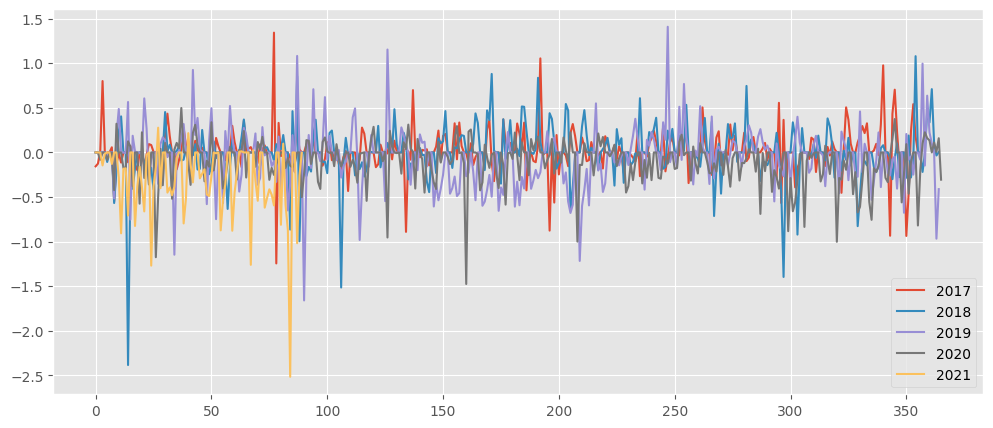

In [14]:
for i in Years:
    df[df.index.year == i].balance.reset_index(drop=True).plot(label=str(i))
plt.legend();

Месячная (судя по ACF и PACF ее нет, иначе бы был рост в районе 30-го лага), но построим график на всякий случай, как будто не жалко

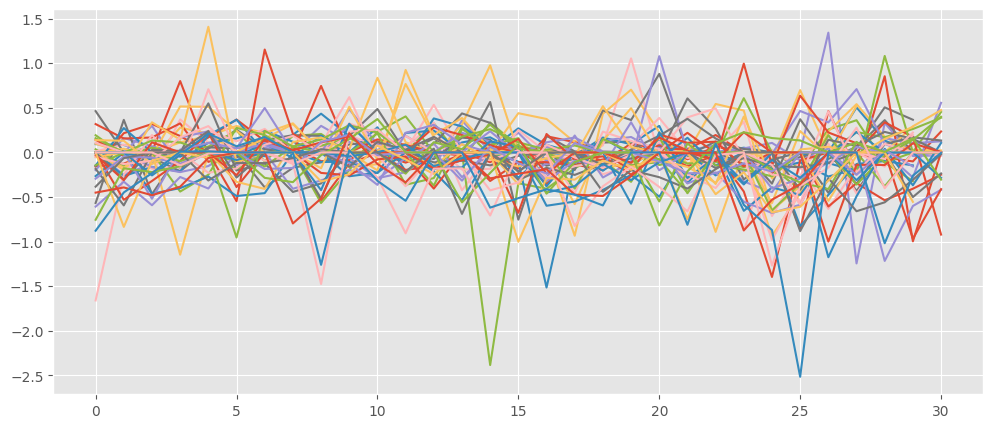

In [15]:
for i in Years:
    for j in range(1, 13):
        df[(df.index.month == j) & (df.index.year == i)].balance.reset_index(drop=True).plot(label=str(i))

Каких-то четких паттернов "большой" сезонности не выявлено

У нас кратные семи лаги повторяются в PACF, можно предположить использование недельной сезонности

Тк 1-й лаг более менее значим, можно попробовать SARIMA (P=4, 0, Q=4, s=7) (p=1, 0, q=1)

In [14]:
y_train, y_test = temporal_train_test_split(df.balance, test_size=0.1)

In [18]:
# y_train

In [12]:
weekly_seasonal = ARIMA(df.balance, order=(1, 0, 1), seasonal_order=(4, 0, 4, 7), freq='D')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
results = weekly_seasonal.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                    balance   No. Observations:                 1543
Model:             ARIMA(1, 0, 1)x(4, 0, [1, 2, 3, 4], 7)   Log Likelihood                -155.757
Date:                                    Sun, 14 Apr 2024   AIC                            335.515
Time:                                            14:27:18   BIC                            399.613
Sample:                                        01-09-2017   HQIC                           359.360
                                             - 03-31-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0758      0.049     -1.541      0.123      -0.172       0.021
ar.L1          0.8746      0.075     11.628      0.000       0.727       1.022
ma.L1         -0.8178      0.088     -9.316      0.000      -0.990      -0.646
ar.S.L7       -0.0306      0.509     -0.060      0.952      -1.028       0.967
ar.S.L14       0.0920      0.056      1.649      0.099      -0.017       0.201
ar.S.L21       0.8591      0.053     16.362      0.000       0.756       0.962
ar.S.L28       0.0466      0.417      0.112      0.911      -0.771       0.865
ma.S.L7        0.1874      0.507      0.370      0.711      -0.805       1.180
ma.S.L14      -0.0273      0.036     -0.766      0.444      -0.097       0.043
ma.S.L21      -0.8803      0.036    -24.530      0.000      -0.951      -0.810
ma.S.L28      -0.1118      0.429     -0.261      0.794      -0.952       0.728
sigma2         0.0738      0.001     57.991      0.000       0.071       0.076
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):              7710.67
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -1.08
Prob(H) (two-sided):                  0.67   Kurtosis:                        13.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

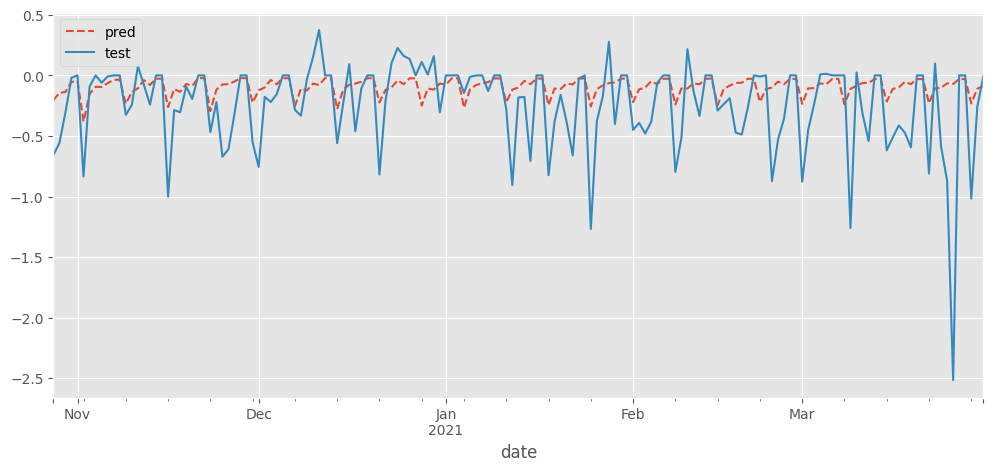

In [15]:
results.predict(start=y_test.index.min(), dynamic= True).plot(label='pred', linestyle='--')
y_test.plot(label='test');
plt.legend();
# df[['riders', 'forecast']].plot(figsize=(12, 8))

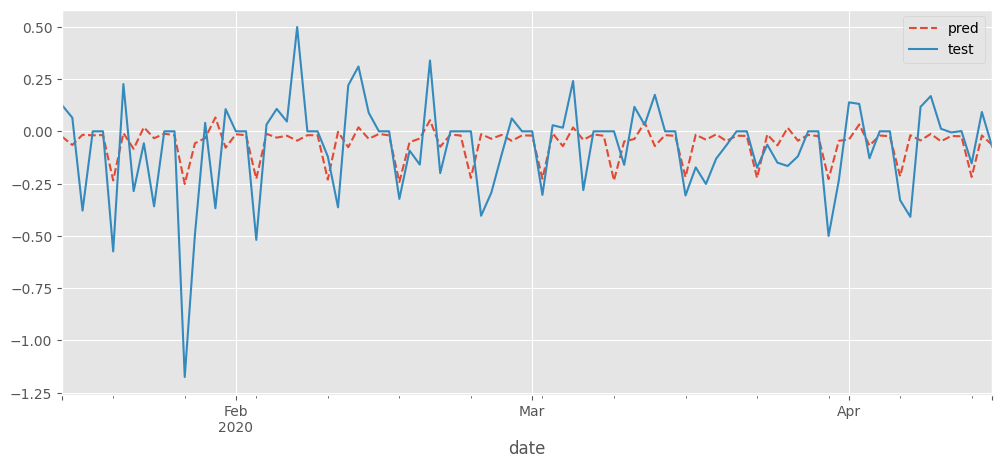

In [16]:
start = pd.Timestamp('2020-01-15')
end = pd.Timestamp('2020-04-15')

results.predict(start=start, end=end, dynamic=True).plot(label='pred', linestyle='--')
df.balance[
(df.balance.index >= start) &
(df.balance.index <= end)].plot(label='test');
plt.legend();

Так, ну как будто какие-то паттерны научились ловить, но мы сильно ошибаемся на больших колебаниях

И, что самое, обидное, модель практически не детектит профициты баланса, т. е. от нее проку особенно не будет

**Здесь два захода**:

1) прогнозировать отдельно Income и Outcome
2) Добавить фичей (SARIMAX)

In [4]:
# creating lag features

target_columns = ['income', 'outcome', 'balance', 'income - outcome']
X = df.drop(columns=target_columns)

# cutting nulls after creating lags 
start = X[X.isnull().sum(axis=1) == 0].index.min()

y, X, income, outcome = df['balance'][start:], X[start:], df['income'][start:], df['outcome'][start:]

assert y.shape[0] == X.shape[0], 'alarm (shape)'
assert y.index.min() == X.index.min(), 'alarm (dates)'

In [5]:
corrs = df[df.notnull().all(axis=1)].corr()

balance_corr_features = list(corrs['balance'][
                            (corrs['balance'].abs() > 0.15)
                            & ~corrs.index.isin(target_columns)
                            ].sort_values()[:7].index)

In [6]:
balance_corr_features

['Monday',
 'year_2021',
 'usd_xr_min_7',
 'usd_xr_mean_7',
 'usd_xr_median_7',
 'usd_xr',
 'usd_xr_max_7']

In [15]:
y_train, y_test = temporal_train_test_split(y, test_size=0.1)

In [9]:
balance_model_class_X = ARIMA(
    endog=y,
    exog = X[balance_corr_features],
     order=(1, 0, 1), seasonal_order=(4, 0, 4, 7),
    freq='D',
)

balance_model_X = balance_model_class_X.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


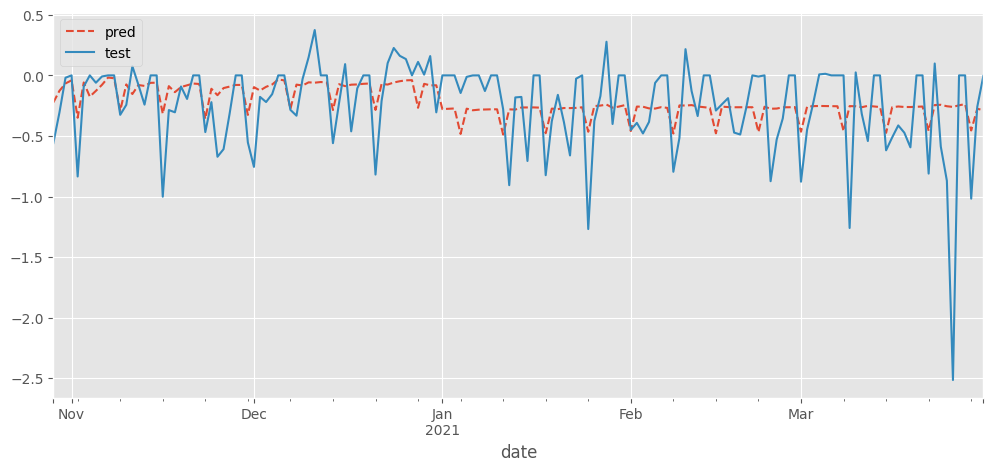

In [16]:
balance_model_X.predict(start=y_test.index.min(), dynamic= True).plot(label='pred', linestyle='--')
y_test.plot(label='test');
plt.legend();
# df[['riders', 'forecast']].plot(figsize=(12, 8))

# Income

Повторим всю ту же процедуру для Income

Тк логика похожая комментировать буду меньше

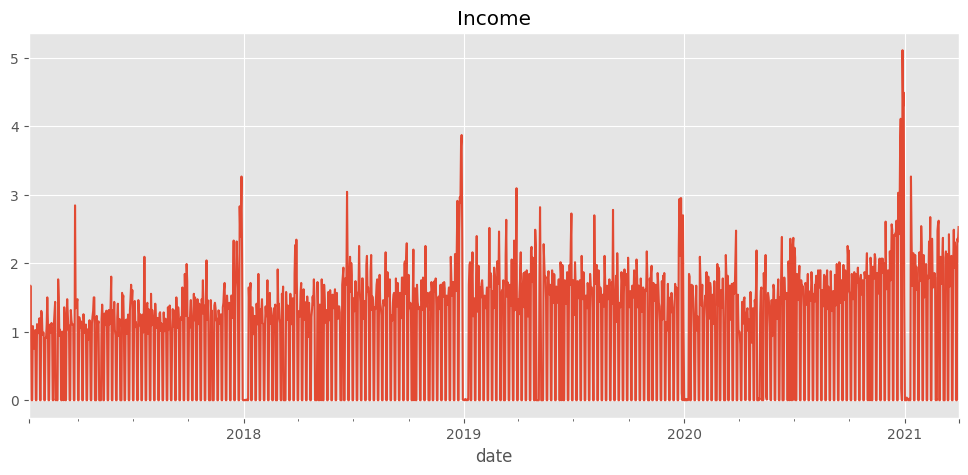

In [17]:
df.income.plot();
plt.title('Income');

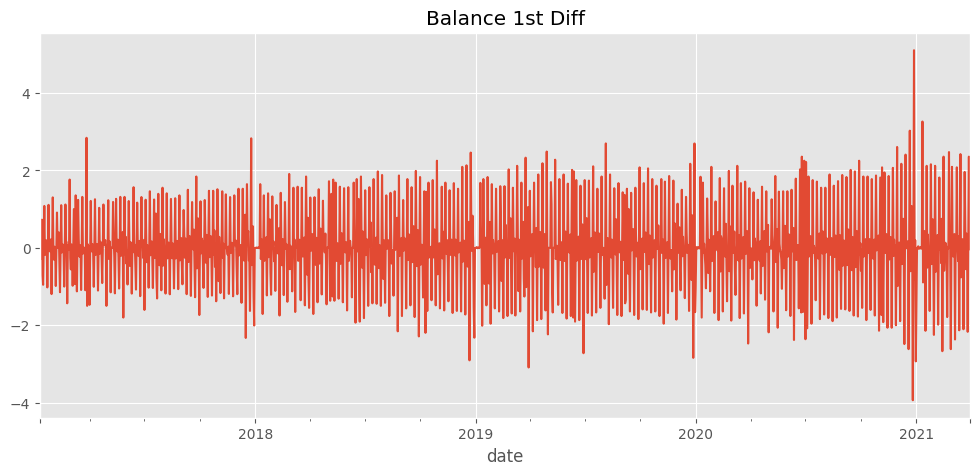

In [18]:
df.income.diff().plot();
plt.title('Balance 1st Diff');

Наблюдаем растущую дисперсию, если успею, надо прикрутить трансформацию Бокса-Кокса

In [31]:
"Balance 1st diff: adf test p-value: {}".format( 
round(
          adfuller(
              df.income.diff().dropna(), maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
          )[1],3
      ))

'Balance 1st diff: adf test p-value: 0.0'

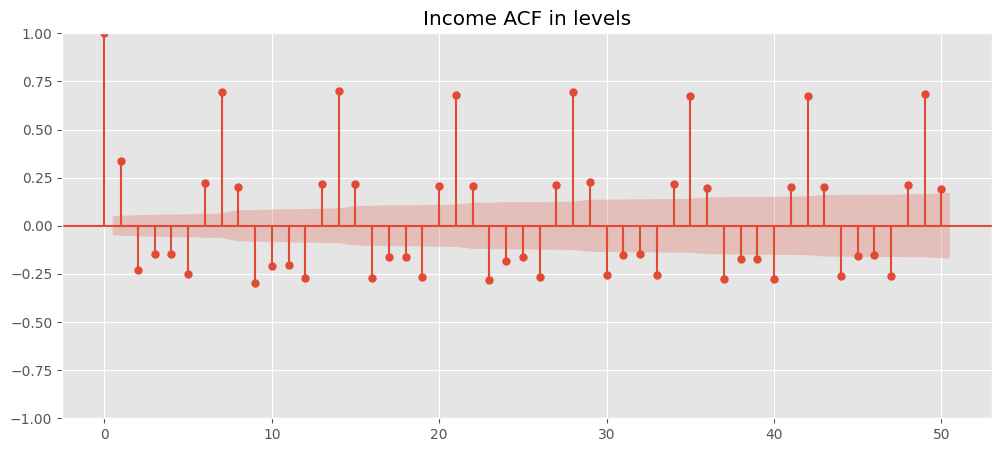

In [50]:
plot_acf(df.income, title='Income ACF in levels', lags=50);

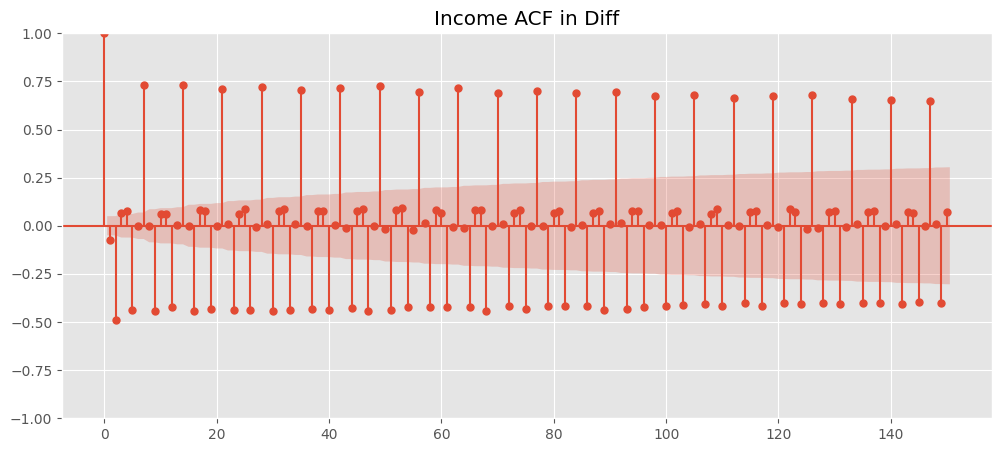

In [52]:
plot_acf(df.income.diff().dropna(), title='Income ACF in Diff', lags=150);

In [49]:
acf_res_income = acf(df.income.diff().dropna(), nlags=50)

acf_lin = []
tr = 0.1
for index, lag in enumerate(acf_res_income):
    if abs(lag) > tr:
        acf_lin.append(index)

f'{acf_lin}'

'[0, 2, 5, 7, 9, 12, 14, 16, 19, 21, 23, 26, 28, 30, 33, 35, 37, 40, 42, 44, 47, 49]'

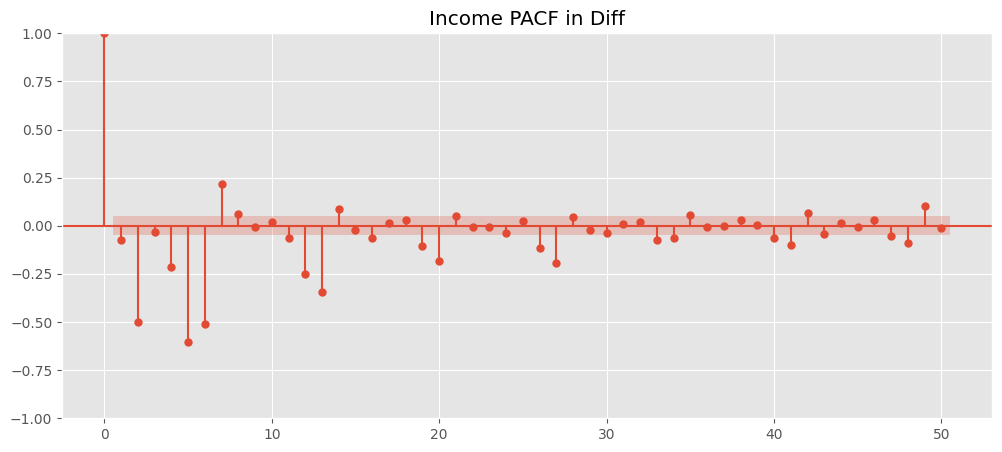

In [54]:
plot_pacf(df.income.diff().dropna(), title='Income PACF in Diff', lags=50);

In [57]:
pacf_res_income = pacf(df.income.diff().dropna(), nlags=50)

pacf_lin = []
tr = 0.15
for index, lag in enumerate(pacf_res_income):
    if abs(lag) > tr:
        pacf_lin.append(index)

f'{pacf_lin}'

'[0, 2, 4, 5, 6, 7, 12, 13, 20, 27]'

$p = 6, d=1, q = 6, P=2, D=1, Q=4, s=7$

In [104]:
income_train, income_test = temporal_train_test_split(income, test_size=0.1)

In [112]:
income_model_class = ARIMA(df.income, 
                           order=([2, 4, 5, 6], 1, [2, 5]),
                           seasonal_order=(2, 0, 4, 7), 
                           freq='D')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [113]:
income_model = income_model_class.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


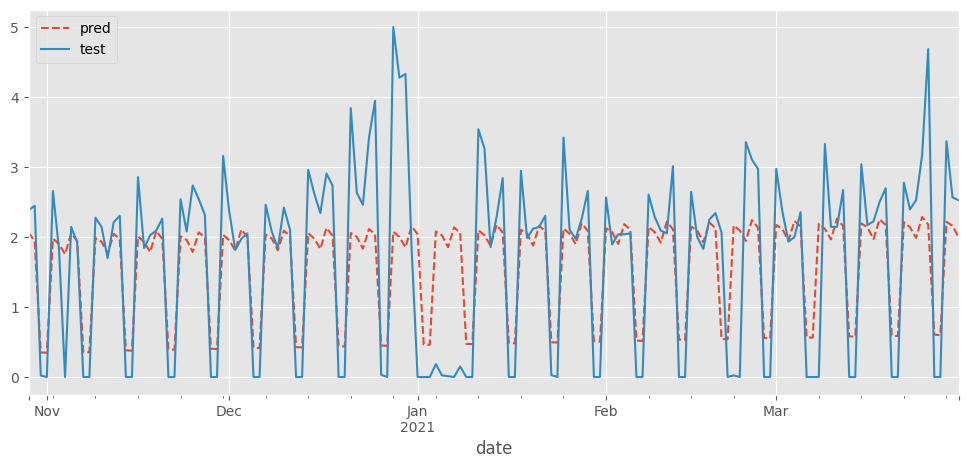

In [114]:
income_model.predict(start=income_test.index.min(), dynamic= True).plot(label='pred', linestyle='--')
income_test.plot(label='test');
plt.legend();
# df[['riders', 'forecast']].plot(figsize=(12, 8))

In [99]:
df

,income,outcome,balance,income - outcome,non_working_day,non_working_day_usd,isholiday,key_rate,mosprime_rub_1m,mosprime_rub_1w,mosprime_rub_2m,mosprime_rub_2w,mosprime_rub_3m,mosprime_rub_6m,mosprime_rub_on,usd_xr,usd_xr_mean_7,usd_xr_std_7,usd_xr_min_7,usd_xr_max_7,usd_xr_median_7,day_before_holiday,day_after_holidays,tax,day_before_tax,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,start_of_month,end_of_month,year_2017,year_2018,year_2019,year_2020,year_2021,January,February,March,April,May,June,July,August,September,October,November,December
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,-0.144836,0,0,0,10.0,10.52,10.44,10.58,10.47,10.58,10.58,10.46,60.6569,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-10,1.068610,1.194182,-0.125572,-0.125572,0,0,0,10.0,10.53,10.40,10.59,10.48,10.59,10.59,10.21,59.8961,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-11,0.944429,0.936663,0.007767,0.007767,0,0,0,10.0,10.53,10.40,10.59,10.48,10.59,10.59,10.23,59.9533,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-12,1.672202,0.875379,0.800391,0.796823,0,0,0,10.0,10.53,10.42,10.59,10.48,10.59,10.59,10.23,60.1614,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-13,0.955924,0.975645,-0.019721,-0.019721,0,0,0,10.0,10.51,10.40,10.58,10.45,10.59,10.59,10.27,59.4978,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,0.000000,1,1,0,4.5,4.90,4.71,5.09,4.76,5.23,5.35,4.68,75.7576,75.190029,0.893932,74.1390,76.1741,75.3585,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,0.000000,0.000000,0.000000,0.000000,1,1,0,4.5,4.90,4.71,5.09,4.76,5.23,5.35,4.68,75.7576,75.421257,0.778663,74.1390,76.1741,75.7576,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,2.356883,3.370738,-1.017679,-1.013855,0,0,0,4.5,4.90,4.69,5.10,4.76,5.28,5.38,4.65,75.7576,75.652486,0.537367,74.6085,76.1741,75.7576,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [118]:
X

date
2017-01-15    0.000000
2017-01-16    1.082341
2017-01-17    0.896334
2017-01-18    0.754759
2017-01-19    0.949877
                ...   
2021-03-27    0.000000
2021-03-28    0.000000
2021-03-29    2.356883
2021-03-30    2.317382
2021-03-31    2.528054
Name: income, Length: 1537, dtype: float64

In [146]:
corrs = df[df.notnull().all(axis=1)].corr()

income_corr_features = list(corrs['income'][
                            (corrs['income'].abs() > 0.15)
                            & ~corrs.index.isin(target_columns)
                            ].sort_values()[:7].index)

In [153]:
income_model_class_X = ARIMA(
    endog=income,
    exog = X[income_corr_features],
    order=([2, 4, 5, 6], 1, [2, 5]),
    seasonal_order=(2, 0, 2, 7), 
    freq='D',
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [154]:
income_model_X = income_model_class_X.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


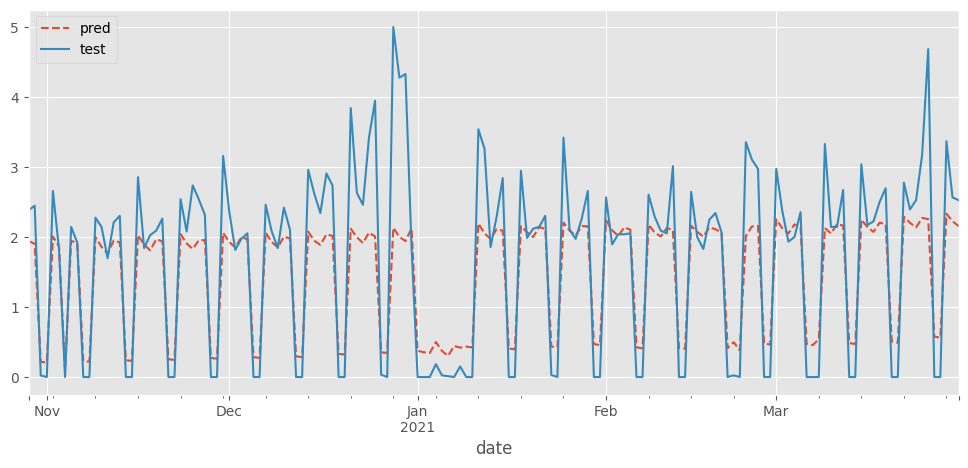

In [155]:
income_model_X.predict(start=income_test.index.min(), dynamic= True).plot(label='pred', linestyle='--')
income_test.plot(label='test');
plt.legend();
# df[['riders', 'forecast']].plot(figsize=(12, 8))

In [63]:
# !pip install pmdarima

In [62]:
# from sktime.forecasting.arima import AutoARIMA

# forecaster = AutoARIMA(sp=52, d=1, max_p=7, max_q=7, suppress_warnings=True)  
# forecaster.fit(df.income)  

# Outcome

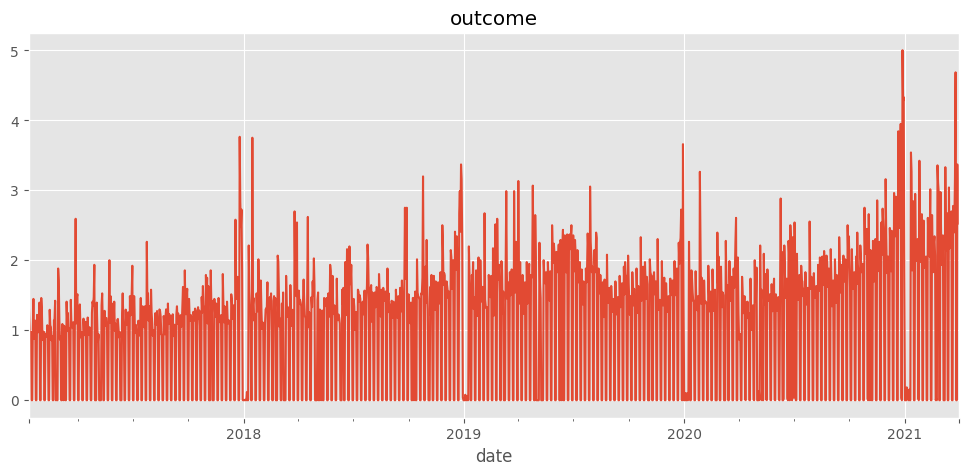

In [157]:
df.outcome.plot();
plt.title('outcome');

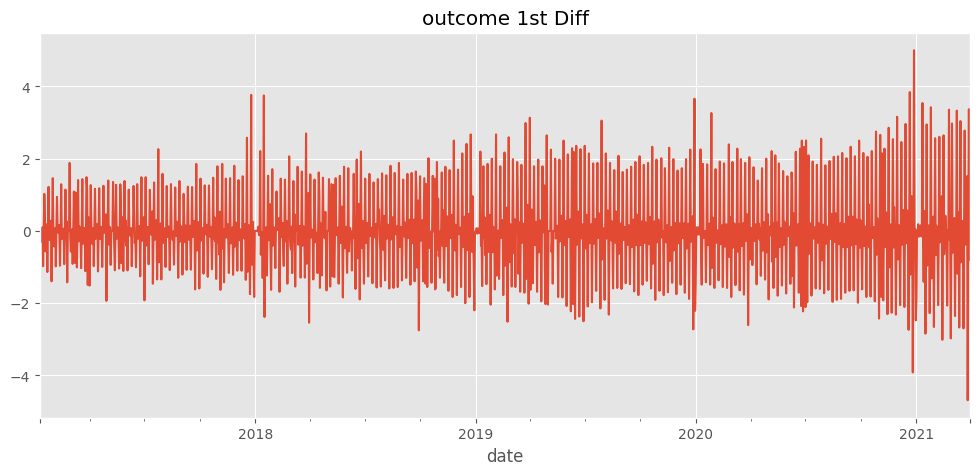

In [158]:
df.outcome.diff().plot();
plt.title('outcome 1st Diff');

Наблюдаем растущую дисперсию, если успею, надо прикрутить трансформацию Бокса-Кокса

In [159]:
"outcome 1st diff: adf test p-value: {}".format( 
round(
          adfuller(
              df.income.diff().dropna(), maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
          )[1],3
      ))

'outcome 1st diff: adf test p-value: 0.0'

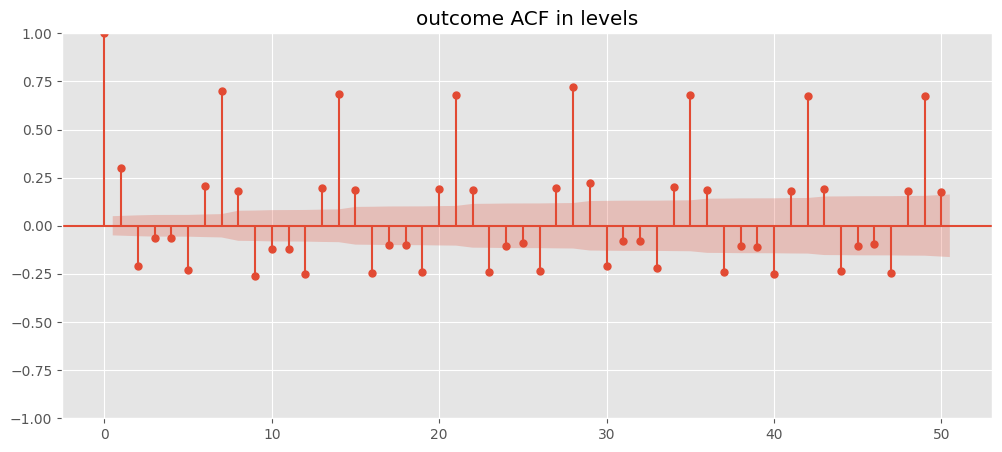

In [160]:
plot_acf(df.outcome, title='outcome ACF in levels', lags=50);

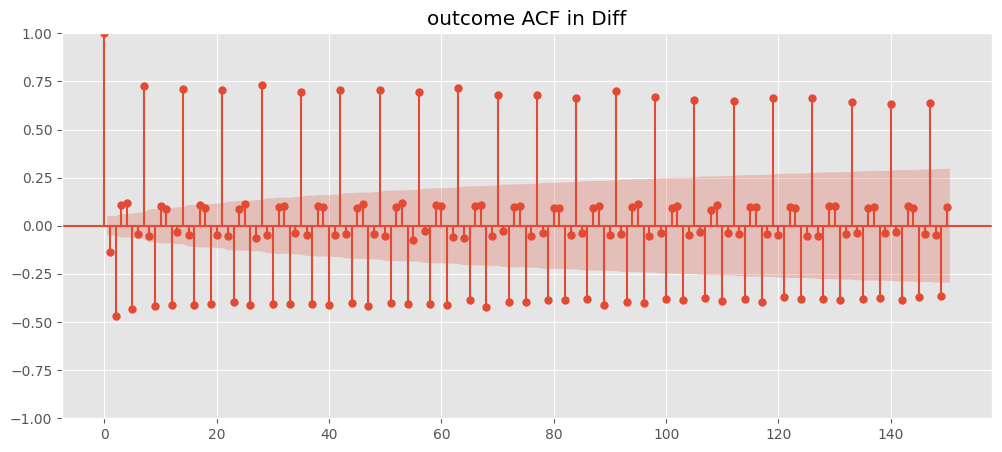

In [161]:
plot_acf(df.outcome.diff().dropna(), title='outcome ACF in Diff', lags=150);

In [162]:
acf_res_outcome = acf(df.outcome.diff().dropna(), nlags=50)

acf_lin_outcome = []
tr = 0.1
for index, lag in enumerate(acf_res_outcome):
    if abs(lag) > tr:
        acf_lin_outcome.append(index)

f'{acf_lin_outcome}'

'[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 14, 16, 17, 19, 21, 23, 25, 26, 28, 30, 32, 33, 35, 37, 38, 40, 42, 44, 46, 47, 49]'

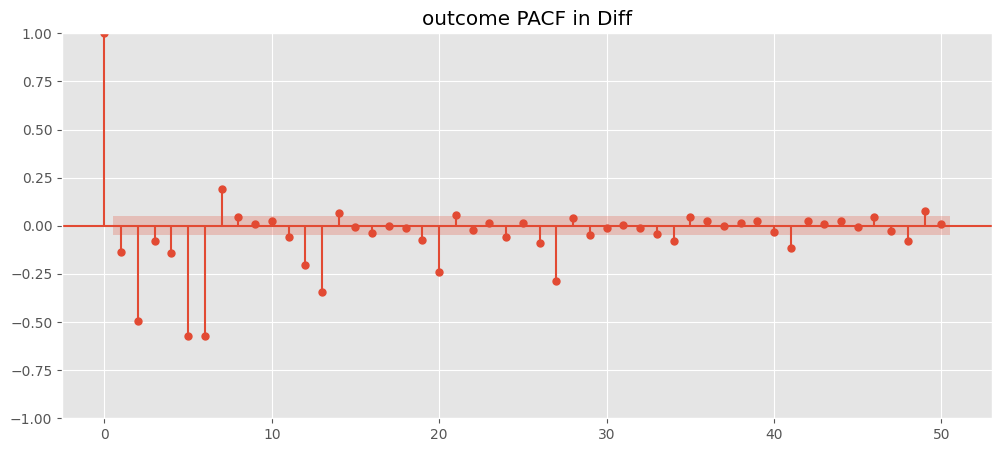

In [163]:
plot_pacf(df.outcome.diff().dropna(), title='outcome PACF in Diff', lags=50);

In [164]:
pacf_res_outcome = pacf(df.outcome.diff().dropna(), nlags=50)

pacf_lin_outcome = []
tr = 0.15
for index, lag in enumerate(pacf_res_outcome):
    if abs(lag) > tr:
        pacf_lin_outcome.append(index)

f'{pacf_lin_outcome}'

'[0, 2, 5, 6, 7, 12, 13, 20, 27, 41]'

$p = 6, d=1, q = 6, P=2, D=1, Q=4, s=7$

In [165]:
outcome_train, outcome_test = temporal_train_test_split(outcome, test_size=0.1)

In [177]:
outcome_model_class = ARIMA(df.outcome, 
                           order=([2, 4, 5, 6], 1, [2, 5]),
                           seasonal_order=(2, 1, 4, 7),trend=None,
                           freq='D')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [178]:
outcome_model = outcome_model_class.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


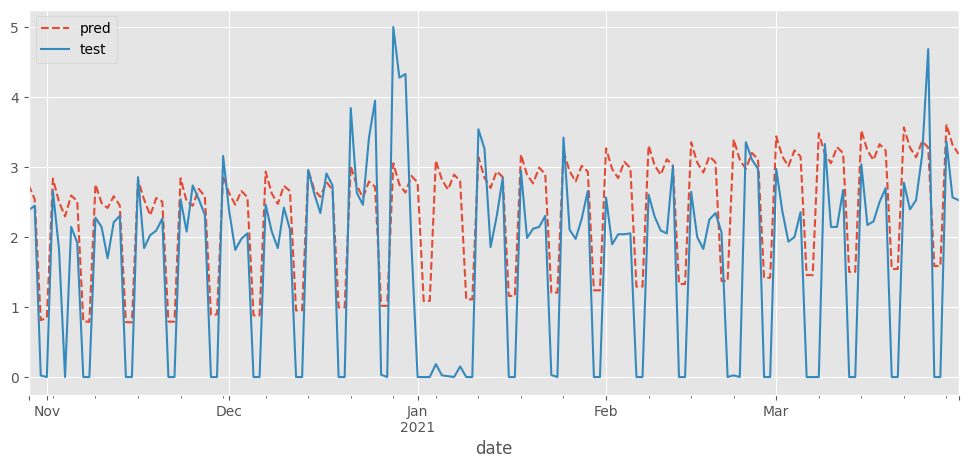

In [179]:
outcome_model.predict(start=outcome_test.index.min(), dynamic= True).plot(label='pred', linestyle='--')
outcome_test.plot(label='test');
plt.legend();
# df[['riders', 'forecast']].plot(figsize=(12, 8))

In [173]:
corrs = df[df.notnull().all(axis=1)].corr()

outcome_corr_features = list(corrs['outcome'][
                            (corrs['outcome'].abs() > 0.15)
                            & ~corrs.index.isin(target_columns)
                            ].sort_values()[:7].index)

In [174]:
outcome_model_class_X = ARIMA(
    endog=outcome,
    exog = X[outcome_corr_features],
    order=([2, 4, 5, 6], 1, [2, 5]),
    seasonal_order=(2, 0, 2, 7), 
    freq='D',
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [175]:
outcome_model_X = outcome_model_class_X.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


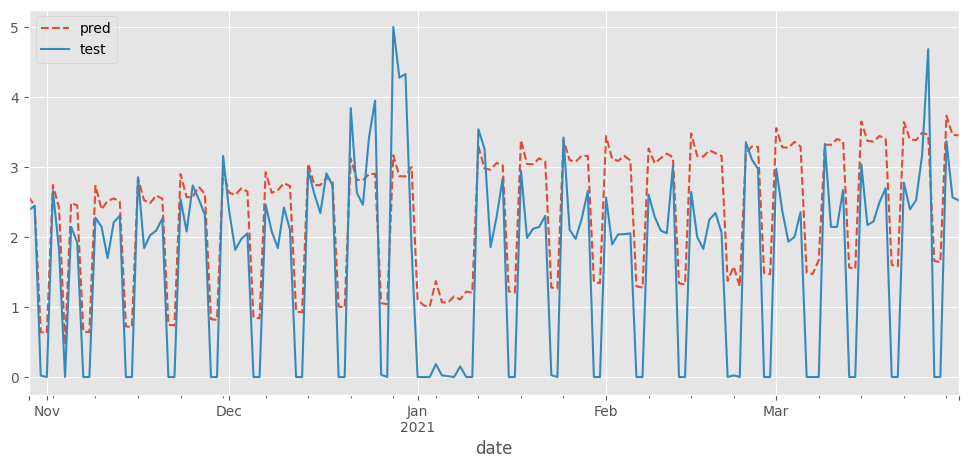

In [176]:
outcome_model_X.predict(start=outcome_test.index.min(), dynamic= True).plot(label='pred', linestyle='--')
outcome_test.plot(label='test');
plt.legend();
# df[['riders', 'forecast']].plot(figsize=(12, 8))